## LLM

In [1]:
import torch as torch
import numpy as np
import pickle as pkl
from tqdm.notebook import tqdm
from transformer_kristianwold.transformer import Transformer
from transformer_kristianwold.optimization import train_step, forward_and_loss, group_decay_parameters, save_checkpoint, load_checkpoint
from transformer_kristianwold.utils import saver, loader
from torch.utils.data import TensorDataset, DataLoader
from IPython.display import clear_output
import matplotlib.pyplot as plt

print("PyTorch version:", torch.__version__)  
print("CUDA toolkit version PyTorch was built with:", torch.version.cuda)  
print("cuDNN version:", torch.backends.cudnn.version()) 
print("cuda available:", torch.cuda.is_available())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_float32_matmul_precision('high')

PyTorch version: 2.7.1+cu128
CUDA toolkit version PyTorch was built with: 12.8
cuDNN version: 90701
cuda available: True


## Load and batch data

In [ ]:
tokenizer = loader("../tokenizers/cnn_tokenizer3.pkl")

start_token_id=tokenizer.token_to_idx["<s>"]
vocab_size=tokenizer.vocab_size

print("Start token id:", start_token_id)
print("Vocab size:", vocab_size)


In [3]:
corpus_train1 = loader("../corpus/cnn_dailymail_highlight_first_train.pkl")
corpus_train2 = loader("../corpus/cnn_dailymail_highlight_last_train.pkl")
corpus_train = torch.cat((corpus_train1, corpus_train2), dim=0)

corpus_test1 = loader("../corpus/cnn_dailymail_highlight_first_test.pkl")
corpus_test2 = loader("../corpus/cnn_dailymail_highlight_last_test.pkl")
corpus_test = torch.cat((corpus_test1, corpus_test2), dim=0)

In [4]:
def batch_data(corpus, batch_length=1024):
    """
    Splits the corpus into batches of size batch_size.
    """
    length = len(corpus)
    batches = length // batch_length
    corpus_truncated = corpus[:batches * batch_length]  # trim to a multiple of batch_length
    corpus_batched = corpus_truncated.view(-1, batch_length)  # reshape into batches

    return corpus_batched

In [5]:
corpus_train_batched = batch_data(corpus_train, batch_length=1024)
corpus_test_batched = batch_data(corpus_test, batch_length=1024)

In [6]:
loader_train = DataLoader(
    corpus_train_batched,
    batch_size=3,
    shuffle=True,       # shuffle every epoch
    drop_last=True      # drop the last incomplete batch
)

loader_test = DataLoader(
    corpus_test_batched,
    batch_size=3,
    shuffle=True,      # no need to shuffle test data
    drop_last=True      # drop the last incomplete batch
)

## Initialize Transformer

In [9]:
torch.manual_seed(42)

embed_dim = 64*18
ff_dim = 4*embed_dim
heads = 18
tf_blocks = 18

model = Transformer(
    embed_dim=embed_dim,
    ff_dim=ff_dim,
    heads=heads,
    tf_blocks=tf_blocks,
    vocab_size=vocab_size,
    max_seq_len=1024,
    dropout=0.1,
    start_token_id=start_token_id,
    use_weight_tying=True
).to(device)

optimizer_grouped_parameters = group_decay_parameters(
    model,
    weight_decay=0.1,
    no_decay=["bias", "LayerNorm.weight"],
    )

filename = "checkpoint_transformer_1epoch.pth"

print("Number of parameters:", model.num_parameters())

Number of parameters: 315778058


In [10]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=5e-5)
scaler = torch.amp.GradScaler("cuda")
loss_train_list = []
loss_test_list = []

num_epochs      = 1
steps_per_epoch = len(loader_train)
warmup_steps    = 1000

def lr_lambda(step):
    if step < warmup_steps:
        return float(step) / float(max(1, warmup_steps))
    return 1.0

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

### Save Model

In [9]:
# save_checkpoint(model, 
#                 optimizer, 
#                 scheduler,
#                 loss_train_list,
#                 loss_test_list, 
#                 filename="models/checkpoint_transformer.pth")

### Load Model

In [10]:
# [model, 
# optimizer, 
# scheduler, 
# loss_train_list, 
# loss_test_list] = load_checkpoint("models/checkpoint_transformer.pth", 
#                                   model, 
#                                   optimizer, 
#                                   scheduler, 
#                                   loss_train_list, 
#                                   loss_test_list)

In [ ]:
optimizer.zero_grad()
model.train()
device = next(model.parameters()).device
accum_steps = 40

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    for step, batch in enumerate(tqdm(loader_train, desc="Training")):
        batch = batch.to(device)
        loss_train = train_step(model, 
                          batch, 
                          criterion, 
                          optimizer, 
                          scaler, 
                          scheduler, 
                          accum_steps,
                          step).item()
        
        if (step+1) % 500 == 0:
            model.eval()
            lr = scheduler.get_last_lr()[0]
            iter_test = iter(loader_test)
            with torch.no_grad():
                loss_test = np.mean([forward_and_loss(model, next(iter_test).to(device), criterion).item() 
                                     for _ in range(accum_steps)])
                print(f"Step {step+1}, Loss: {loss_train:<.3f}, Loss_eval: {loss_test:<.3f}, Learning Rate: {lr:3e}")
            model.train()

            loss_train_list.append(loss_train)
            loss_test_list.append(loss_test)

            
        if (step+1) % 5000 == 0:
            save_checkpoint(model, 
                            optimizer, 
                            scheduler,
                            loss_train_list,
                            loss_test_list, 
                            filename=filename)
            
    save_checkpoint(model, 
                    optimizer, 
                    loss_train_list,
                            loss_test_list,  
                    filename=filename)


Epoch 1/1


Training:   0%|          | 0/175316 [00:00<?, ?it/s]

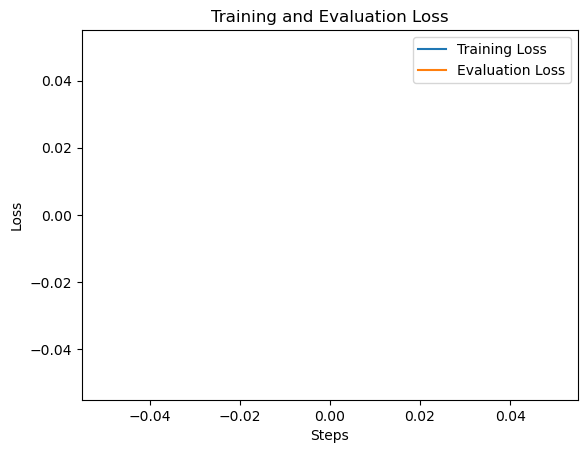

In [ ]:
plt.plot(loss_train_list)
plt.plot(loss_test_list)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and Evaluation Loss")
plt.legend(["Training Loss", "Evaluation Loss"])
plt.show()
